In [1]:
import autograd.numpy as np
from autograd import jacobian, hessian, grad

import scipy
import matplotlib.pyplot as plt

from itertools import product

### Задача 4.1.10
Требуется, используя метода Ньютона, с точностью до $\varepsilon = 10^{-6}$ найти решение системы уравнений:
$$
\begin{cases}
\sin(x_1 + x_2) - x_2 - 1.5 = 0 \\
x_1 + \cos(x_2 - 0.5) - 0.5 = 0
\end{cases}
$$

In [2]:
def f1(x):
    assert x.shape[0] == 2
    x1, x2 = x[0], x[1]
    return np.sin(x1 + x2) - x2 - 1.5


def f2(x):
    assert x.shape[0] == 2
    x1, x2 = x[0], x[1]
    return x1 + np.cos(x2 - 0.5) - 0.5


def F(x):
    assert x.shape == (2,)
    return np.array([f1(x), f2(x)], dtype=np.double)


W = jacobian(F)

#### Визуализация корней

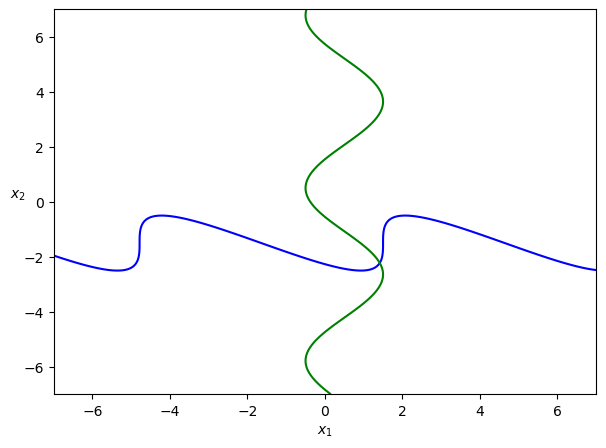

In [3]:
# Preparing data
x1_min, x1_max = -7, 7
x2_min, x2_max = -7, 7

x1_list = np.linspace(x1_min, x1_max, 500)
x2_list = np.linspace(x2_min, x2_max, 500)

x1_arr, x2_arr = np.meshgrid(x1_list, x2_list)
x_arr = np.array([x1_arr, x2_arr], dtype=np.double) 

f1_arr = f1(x_arr)
f2_arr = f2(x_arr)

# Plotting
plt.figure(figsize=(7, 5))

plt.contour(x1_arr, x2_arr, f1_arr, [0], colors=["blue"])
plt.contour(x1_arr, x2_arr, f2_arr, [0], colors=["green"])

plt.xlabel("$x_1$")
plt.ylabel("$x_2$", rotation=0)


plt.savefig("plots/roots_loc.png", format='png')
plt.show()

#### Решение системы

In [4]:
def newton_solve(x_init, eps=1e-6):
    x = x_init.astype(np.double)
    delta = np.linalg.solve(W(x), F(x))
    error = np.linalg.norm(delta)
    n_iter = 0
    
    while error > eps:
        delta = np.linalg.solve(W(x), F(x))
        error = np.linalg.norm(delta)
        x -= delta
        n_iter += 1

    return x, n_iter

In [5]:
x_init1 = np.array([-2.0, 0.0], dtype=np.double) # First start point
x_init2 = np.array([1.0, -1.5], dtype=np.double) # Second start point

my_x1, n_iter1 = newton_solve(x_init1)
my_x2, n_iter2 = newton_solve(x_init2)

scipy_x1 = scipy.optimize.fsolve(F, x_init1, xtol=1e-6)
scipy_x2 = scipy.optimize.fsolve(F, x_init2, xtol=1e-6)

In [6]:
print(f"Starting point: ({x_init1[0]}, {x_init1[1]})")
print(f"Newton's method solution: ({my_x1[0]:.8f}, {my_x1[1]:.8f})")
print(f"Scipy function solution: ({scipy_x1[0]:.8f}, {scipy_x1[1]:.8f})")
print(f"Difference: {np.linalg.norm(my_x1 - scipy_x1)}")
print(f"Newton's method iterations number: {n_iter1}")

print()

print(f"Starting point: ({x_init2[0]}, {x_init2[1]})")
print(f"Newton's method solution: ({my_x2[0]:.8f}, {my_x2[1]:.8f})")
print(f"Scipy function solution: ({scipy_x2[0]:.8f}, {scipy_x2[1]:.8f})")
print(f"Difference: {np.linalg.norm(my_x1 - scipy_x1)}")
print(f"Newton's method iterations number: {n_iter2}")

Starting point: (-2.0, 0.0)
Newton's method solution: (1.41423304, -2.22440735)
Scipy function solution: (1.41423304, -2.22440735)
Difference: 1.4929990887555053e-09
Newton's method iterations number: 7

Starting point: (1.0, -1.5)
Newton's method solution: (1.41423304, -2.22440735)
Scipy function solution: (1.41423304, -2.22440735)
Difference: 1.4929990887555053e-09
Newton's method iterations number: 5


### Задача 4.5.3
Даны точки $P_1 = (15.5,\ 6.4,\ 12.162)^T$, $P_2 = (8.22,\ 5.879,\ 9.122)^T$, $P_3 = (14.531,\ 3.464,\ 5.375)^T$ 
и поверхность
$$
S: \frac{(x_1)^2}{a_1} + \frac{(x_2)^2}{a_2} = 2x_3
$$
где $a_1 = 7.75$, $a_2 = 3.2$.

Необходимо с помощью метода Ньютона среди точек $P_1$, $P_2$, $P_3$ найти наиболее и наименее удалённую от поверхности $S$.

#### Нахождение расстояний

In [7]:
P1 = np.array([15.5, 6.4, 12.162], dtype=np.double)
P2 = np.array([8.22, 5.879, 9.122], dtype=np.double)
P3 = np.array([14.531, 3.464, 5.375], dtype=np.double)

In [8]:
a1 = 7.75
a2 = 3.2

In [9]:
def param2coord(params):
    """
    Transforms generalized coordinates of specified point on the 
    elliptical parabaloid into Cartesian coordinates.
    """
    u, teta = params[0], params[1]
    x1 = np.sqrt(a1) * u * np.cos(teta)
    x2 = np.sqrt(a2) * u * np.sin(teta)
    x3 = 0.5 * (u ** 2)
    return np.array([x1, x2, x3], dtype=np.double)


def H(params, x):
    """
    Computes square of distance between point on the elliptical
    parabaloid and specified point (target function).
    
    :param np.ndarray params: array of shape (2,) - u and teta.
    :param np.ndarray x: other point.
    :return float: euclidean distance.
    """
    x_vec = param2coord(params)
    return np.sum((x_vec - x) ** 2)

In [10]:
def newton_minimize(func, x0, gamma=1.0, eps=1e-7, max_iter=250):
    x = x0.astype(np.double)
    f_grad = grad(func)
    f_hessian = hessian(func)
    
    iter_n = 0

    while np.linalg.norm(f_grad(x)) > eps:
        x -= gamma * np.linalg.solve(f_hessian(x), f_grad(x))
        iter_n += 1

        if iter_n >= max_iter:
            break
    return x


def compute_dist(p, return_point=False):
    """
    Computes distance between specified point p and 
    the elliptical parabaloid. 

    :param np.ndarray p: cartesian coordinates of point.
    :param bool return_point: if True will be returned distance and coordinates of closest point,
        if False will be returned only distance. Default to False.
    """
    param0 = np.array([7.0, np.pi/8], dtype=np.double)
    def get_H(param):
        return H(param, p)

    opt_param = newton_minimize(get_H, param0)
    opt_h = get_H(opt_param)

    # Some heuristic
    u_max = np.linalg.norm(p)
    u_step = u_max/20

    u_list = np.arange(0.0, u_max, u_step)
    teta_list = np.linspace(0.0, 2*np.pi, 20, endpoint=True)

    for u, teta in product(u_list, teta_list):
        init_param = np.array([u, teta], dtype=np.double)
        param = newton_minimize(get_H, init_param)
        h = get_H(param)
        
        if h < opt_h:
            opt_param = param
            opt_h = h

    if return_point:
        return np.sqrt(opt_h), param2coord(opt_param)
    return np.sqrt(opt_h)

In [11]:
p1_dist = compute_dist(P1)
p2_dist = compute_dist(P2)
p3_dist = compute_dist(P3)

print(f"Distance between the elliptical parabaloid and P1: {p1_dist:.4f}")
print(f"Distance between the elliptical parabaloid and P2: {p2_dist:.4f}")
print(f"Distance between the elliptical parabaloid and P3: {p3_dist:.4f}")

Distance between the elliptical parabaloid and P1: 3.6474
Distance between the elliptical parabaloid and P2: 0.2754
Distance between the elliptical parabaloid and P3: 4.8716


#### Графическое изображение точек и поверхности

In [107]:
r1, r2 = np.sqrt(a1), np.sqrt(a2)

u_list = np.linspace(0.1, 5.0, 250)
teta_list = np.linspace(0.0, 2*np.pi, 250)

u_arr, teta_arr = np.meshgrid(u_list, teta_list)

x1_arr = r1 * u_arr * np.cos(teta_arr)
x2_arr = r2 * u_arr * np.sin(teta_arr)
x3_arr = 0.5 * (u_arr ** 2)

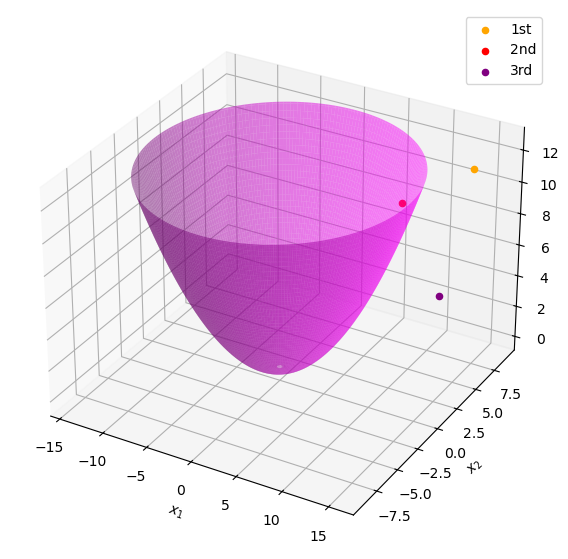

In [108]:
fig = plt.figure(figsize=(10, 7))
ax = fig.add_subplot(projection='3d')

ax.plot_surface(x1_arr, x2_arr, x3_arr, rstride=1, cstride=4, color='magenta', alpha=0.5)
ax.scatter([P1[0]], [P1[1]], [P1[2]], color="orange", label="1st")
ax.scatter([P2[0]], [P2[1]], [P2[2]], color="red", label="2nd")
ax.scatter([P3[0]], [P3[1]], [P3[2]], color="purple", label="3rd")

ax.set_xlabel("$x_1$")
ax.set_ylabel("$x_2$")
ax.set_zlabel("$x_3$")

plt.legend()

plt.savefig("plots/surface_distance.png", format='png')
plt.show()

### Задача 5.1.10
Дана системы $Ax=b$. Требуется найте решение данной системы с помощью метода Гаусса. 
Выполнить 10 итераций по методу Зейделя. После этого, принимая решение с помощью метода Гаусса за точное,
найти абсолютную погрешность итерационного решения.

Матрица $A$ и вектор $b$ задаются соотношениями:
$$
A = \begin{pmatrix}
49.5 & 12.52 & 16.12 & 19.80 \\
0 & 27.1 & 1.64 & 23.76 \\
12.87 & 11.52 & 40 & -14.85 \\
0 & 4.32 & 0.12 & 6.27
\end{pmatrix}
\ \ \ \ \
b = \begin{pmatrix}
-92.98 \\ 25.46 \\ -26.76 \\ -1.15
\end{pmatrix}
$$

In [18]:
A = np.array([
    [49.5, 12.52, 16.12, 19.80],
    [0, 27.1, 1.64, 23.76],
    [12.87, 11.52, 40, -14.85],
    [0, 4.32, 0.12, 6.27]
]).astype(np.double)

b = np.array(
    [-92.98, 25.46, -26.76, -1.15]    
).astype(np.double)

In [19]:
x_true = np.linalg.solve(A, b)

In [20]:
def transform(A, b):
    """
    Transforms sytem Ax=b to view of x=Bx+c
    :return tuple[np.ndarray, np.ndarray]: matrices B and c.
    """
    n = A.shape[0]
    A_copy = np.copy(A)
    b_copy = np.copy(b)
    
    for i in range(n):
        # Avoid zeros on diagonal
        j = i + np.argmax(np.abs(A_copy[i:, i]))
        # Swap
        A_copy[i], A_copy[j] = A_copy[j], A_copy[i]
        b_copy[i], b_copy[j] = b_copy[j], b_copy[i]

    B = np.zeros((n, n))
    c = np.zeros(n)
    for i in range(n):
        for j in range(n):
            B[i,j] = 0 if i==j else -A_copy[i, j]/A_copy[i, i]
        c[i] = b_copy[i] / A_copy[i, i] 
    
    return B, c
            


def check(B):
    """
    Checks a sufficient condition for the convergence of iterative methods.
    """
    return np.linalg.norm(B, ord=+np.inf) < 1.0

In [21]:
B, c = transform(A, b)
check(B)

True

In [22]:
def zeid(B, c, x0, n_iter=10):
    x = x0
    for _ in range(n_iter):
        x = np.dot(B, x) + c
    return x

In [23]:
def abs_error(x_true, x_pred):
    return np.linalg.norm(x_true - x_pred, ord=+np.inf)

In [24]:
n = B.shape[0]
x0_1 = np.zeros(n, dtype=np.double)
x0_2 = np.ones(n, dtype=np.double)

x_zeid1 = zeid(B, c, x0_1)
x_zeid2 = zeid(B, c, x0_2)

print("Experiment 1")
print(f"Start solution approximation: {np.round(x0_1, 4)}")
print(f"The Seidel solution (10 iterations): {np.round(x_zeid1, 4)}")
print(f"Absolute error: {abs_error(x_true, x_zeid1)}")

print()

print("Experiment 2")
print(f"Start solution approximation: {np.round(x0_2, 4)}")
print(f"The Seidel solution (10 iterations): {np.round(x_zeid2, 4)}")
print(f"Absolute error: {abs_error(x_true, x_zeid2)}")

print()
print(f"True solution: {np.round(x_true, 4)}")

Experiment 1
Start solution approximation: [0. 0. 0. 0.]
The Seidel solution (10 iterations): [-1.2549  2.7015 -1.7338 -1.9861]
Absolute error: 0.2984609353406662

Experiment 2
Start solution approximation: [1. 1. 1. 1.]
The Seidel solution (10 iterations): [-1.1651  2.7979 -1.6921 -1.8861]
Absolute error: 0.32597706608569377

True solution: [-1.101   3.     -2.     -2.2121]


### Задача 5.4.4
Дана система уравнений $x = Bx + c$, где $B=B(t)$, $t = -1,\ -0.8, \dots, 0.8,\ 1$ - параметр.

Необходимо:
1) Построить график (или гистрограмму) зависимости нормы $||B||_{\infty}$ от параметра $t$. По этому графику определить, при каких значениях $t$ выполнено достаточное условие сходимости итерационных методов.
2) Для наибольшего из значений $t$, при которых выполнение условие сходимости, решить с точностью $\varepsilon=10^{-5}$ систему $x=Bx+c$.

$$
B = \begin{pmatrix}
    -0.2 & \cos(3t) & 0.1 & 0.3 \\
    0.1 & 0.11 & 0.4 & -0.05 \\
    0.3 & 0.1 & \sin(3t) + \cos(2t) & 0.1 \\
    0.2 & -0.12 & 0.1 & 0.09
\end{pmatrix}
\ \ \ \ \
b = \begin{pmatrix}
0 \\ 1 \\ 2 \\ 3
\end{pmatrix}
$$

In [28]:
c = np.array([0, 1, 2, 3]).astype(np.double)
t_list = np.arange(-1.0, 1.1, 0.2)

def get_B(t: float):
    return np.array([
        [-0.2, np.cos(3*t), 0.1, 0.3],
        [0.1, 0.11, 0.4, -0.05],
        [0.3, 0.1, np.sin(3*t) + np.cos(2*t), 0.1],
        [0.2, -0.12, 0.1, 0.09]
    ]).astype(np.double)

#### График нормы 

In [73]:
norm_list = np.zeros_like(t_list)
color_list = []

for i, t in enumerate(t_list):
    matrix_norm = np.linalg.norm(get_B(t), ord=+np.inf)
    norm_list[i] = matrix_norm
    if matrix_norm < 1.0:
        color_list.append("magenta")
    else:
        color_list.append("red")

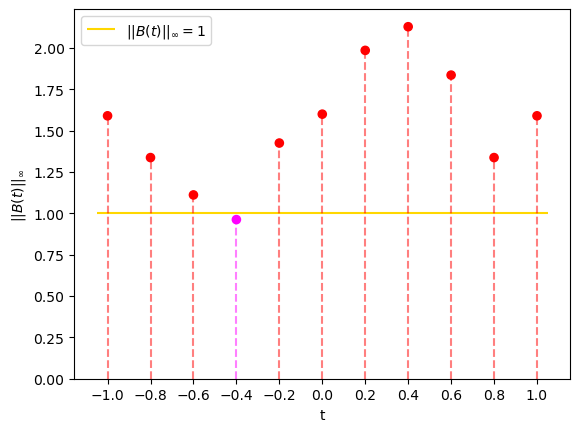

In [106]:
plt.scatter(t_list, norm_list, color=color_list, s=35)

plt.hlines(y=1.0, xmin=-1.05, xmax=1.05, color="gold", label="$||B(t)||_{\infty}=1$")
plt.vlines(x=t_list, ymin=0, ymax=norm_list, color=color_list, ls='--', alpha=0.5)

plt.ylim(bottom=0.0)
plt.legend(loc='upper left')

plt.xticks(t_list, rotation=0)
plt.xlabel("t")
plt.ylabel("$||B(t)||_{\infty}$")

plt.savefig("plots/matrix_norm.png", format='png')

plt.show()

#### Решение системы 

In [95]:
t_arr = t_list[np.argwhere(norm_list < 1.0)[0]]
t_arr

array([-0.4])

In [98]:
B = get_B(t_arr[0])

In [109]:
def find_solution(B, c, eps=1e-5, max_iter=250):
    n = c.shape[0]
    # First iteration step
    x_prev = np.zeros(n).astype(np.double)
    x_current = np.dot(B, x_prev) + c

    iter_n = 1
    while np.linalg.norm(x_current - x_prev, ord=+np.inf) > eps/2:
        x_prev = x_current
        x_current = np.dot(B, x_current) + c
        if iter_n >= max_iter:
            break
    return x_current

In [110]:
x = find_solution(B, c)

print(f"Solution for the system: {np.round(x, 5)}")

Solution for the system: [1.81394 2.26257 2.54025 3.67616]
